In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../code')

In [3]:
from model import get_model
import torch
from predict import *
from glob import glob
import matplotlib.pyplot as plt
from data.functional import collate_mask_fn
import numpy as np
from utils.metrics import cal_mAP

In [6]:
filelist = []

for root, dirs, files in os.walk('../params/effunet_b4/f4'):
    for file in files:
        #append the file name to the list
        filelist.append(os.path.join(root,file))
print('\n'.join(filelist))

../params/effunet_b4/f4/epoch=39-precision=0.8217.ckpt
../params/effunet_b4/f4/epoch=79-precision=0.8344.ckpt
../params/effunet_b4/f4/epoch=100-precision=0.8284.ckpt


In [8]:
model = get_model('effunet_b4')

In [11]:
pretrain = torch.load('../params/effunet_b4/f00_exp_fpa_8/ckpt/epoch=97-precision=0.8480.ckpt')
state_dict = {k[5:]:v for k,v in pretrain['state_dict'].items()}
model.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
filelist = filelist[1:]

In [8]:
filelist

['../params/effunet_b4/f00_exp_fpa_8/ckpt/epoch=42-precision=0.8551.ckpt',
 '../params/effunet_b4/f00_exp_fpa_8/ckpt/epoch=97-precision=0.8480.ckpt',
 '../params/effunet_b4/f00_exp_fpa_8/ckpt/epoch=100-precision=0.8488.ckpt']

## Find best threshold

In [8]:
root_ds = '../dataset'
cross_validation = True
fold_val_idx = 2

# DataFrame chứa toàn bộ train_id và đã được chia fold
df = pd.read_csv(os.path.join(root_ds, 'folds.csv'), index_col='id')
total_sample = len(df.index)
print('Total numper of sample:', total_sample)

val_df = df.loc[df.fold == 0].reset_index()
val_ds = TGSSaltDataset(root_ds, val_df, transforms=TGSTransform(augment_strategy=0)) # Không augmentation cho valid set
val_dl = DataLoader(val_ds, batch_size=16, num_workers=4, collate_fn=collate_mask_fn, pin_memory=True)

Total numper of sample: 4000


In [9]:
preds_test = pred_all(model, val_dl, True, is_valid=True)
preds_test = torch.cat(preds_test, dim=0).unsqueeze(1)
preds_101 = resize_to_orig(preds_test)

  0%|          | 0/51 [00:00<?, ?it/s]/python/lib/python3.8/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 51/51 [00:11<00:00,  4.39it/s]


In [10]:
del preds_test
val_ds.transforms = None
val_df["masks"] = [np.array(val_ds[idx][1]) / 255 for idx in val_df.index]
val_df.head()
true_masks = torch.tensor(val_df['masks'])
del df, val_df, val_ds, val_dl

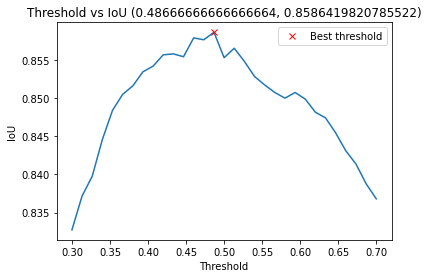

In [11]:
thresholds = np.linspace(0.3, 0.7, 31)
mAPs = np.array([cal_mAP(preds_101, true_masks, threshold) for threshold in thresholds])
threshold_best_index = np.argmax(mAPs) 
mAP_best = mAPs[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, mAPs)
plt.plot(threshold_best, mAP_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, mAP_best))
plt.legend()

## Submit

In [9]:
for i, f in enumerate(filelist):
    pretrain = torch.load(f)
    state_dict = {k[5:]:v for k,v in pretrain['state_dict'].items()}
    model.load_state_dict(state_dict)
    
    
    add_depth=False
    resize_pad=False 
    tta_flip=True
    data_root = '../dataset'
    batch_size=16
    num_workers=2
    pred_threshold=0.5

    df = pd.read_csv(os.path.join(data_root, 'folds.csv'), index_col='id')
    depths = pd.read_csv(os.path.join(data_root, 'depths.csv'), index_col='id')
    test_df = depths.loc[~depths.index.isin(df.index)].reset_index()
    ds_test = TGSSaltDataset(data_root, test_df, image_set='test', transforms=TGSTransform(augment_strategy=0, add_depth=add_depth,resize_pad=resize_pad))
    test_dl = DataLoader(ds_test,
                          shuffle=False,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          pin_memory=True)
    preds_test = pred_all(model, test_dl, tta_flip)
    preds_test = torch.cat(preds_test, dim=0).unsqueeze(1)
    preds_101 = resize_to_orig(preds_test)
    
    np.save(f'../predictions/fold4_snap{i}', preds_101.cpu().numpy())
    sub = build_summission((preds_101.cpu().numpy() > 0.5).astype(int), ds_test.image_ids)
    sub.to_csv(f'effb4_f4_snap{i}.csv')    
    del preds_101

  0%|          | 0/1125 [00:00<?, ?it/s]/python/lib/python3.8/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 1125/1125 [04:20<00:00,  4.32it/s]


Encode time = 1.150395393371582 s


100%|██████████| 1125/1125 [04:19<00:00,  4.33it/s]


Encode time = 1.1426024436950684 s


100%|██████████| 1125/1125 [04:19<00:00,  4.33it/s]


Encode time = 1.1991512775421143 s


In [12]:
add_depth=False
resize_pad=False 
tta_flip=True
data_root = '../dataset'
batch_size=16
num_workers=2
pred_threshold=0.5

df = pd.read_csv(os.path.join(data_root, 'folds.csv'), index_col='id')
depths = pd.read_csv(os.path.join(data_root, 'depths.csv'), index_col='id')
test_df = depths.loc[~depths.index.isin(df.index)].reset_index()
ds_test = TGSSaltDataset(data_root, test_df, image_set='test', transforms=TGSTransform(augment_strategy=0, add_depth=add_depth,resize_pad=resize_pad))
test_dl = DataLoader(ds_test,
                      shuffle=False,
                      batch_size=batch_size,
                      num_workers=num_workers,
                      pin_memory=True)
preds_test = pred_all(model, test_dl, tta_flip)
preds_test = torch.cat(preds_test, dim=0).unsqueeze(1)
preds_101 = resize_to_orig(preds_test)

  0%|          | 0/1125 [00:00<?, ?it/s]/python/lib/python3.8/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 1125/1125 [04:14<00:00,  4.42it/s]


In [13]:
np.save('../predictions/fold0_snap1', preds_101.cpu().numpy())

In [14]:
sub = build_summission((preds_101.cpu().numpy() > 0.5).astype(int), ds_test.image_ids)

Encode time = 1.2046959400177002 s


In [15]:
preds_101.size()

torch.Size([18000, 101, 101])

In [16]:
sub.to_csv('effb4_f0_snap1.csv')

In [17]:
del preds_101

## Load pre prediction

In [10]:
s0 = np.load('../predictions/fold4_snap0.npy')
s1 = np.load('../predictions/fold4_snap1.npy')
swa = np.load('../predictions/fold4_snap2.npy')

In [11]:
p = s0 + s1 + swa

In [12]:
p /= 3

In [13]:
sub = build_summission((p > 0.5).astype(int), ds_test.image_ids)

Encode time = 1.0988199710845947 s


In [14]:
sub.to_csv('fold4.csv')

In [15]:
del s0, s1, swa 

In [16]:
np.save('../predictions/fold4', p)

In [17]:
f0 = np.load('../predictions/fold0.npy')
f1 = np.load('../predictions/fold1.npy')
f2 = np.load('../predictions/fold2.npy')
f3 = np.load('../predictions/fold3.npy')
f4 = np.load('../predictions/fold4.npy')

In [18]:
p = f0 + f1 + f2 + f3 + f4

In [19]:
p /= 5

In [20]:
sub = build_summission((p > 0.5).astype(int), ds_test.image_ids)

Encode time = 1.0969245433807373 s


In [21]:
sub.to_csv('5f.csv')